# Peaking emissions

* A key step on the way to reducing emissions is for them to peak, at both a national and global level
* This notebook reads in emissions data (either national totals or subsectors) and assesses how many countries have peaked. 
* The criteria for 'peaking' are as follows: 
    * a 'maxima' in emissions was reached 4 or more years before the end of the timeseries
    * over the last 5 years, emissions have decreased
    * [Optional] over the last 5 years, emissions have decreased by a certain amount?
    

In [42]:
# import modules

# system
import sys, os, re

# for analysis
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn

# global stocktake tools
from gst_tools.make_plots import *
import gst_tools.gst_utils as utils

from shortcountrynames import to_name


In [2]:
# User specs

data_file_name = 'PRIMAP-hist_v2.0_Energy-CO2.csv'


In [3]:
# Read the data

# read the data from file 
fname_in = os.path.join('proc-data', data_file_name)
data = pd.read_csv(fname_in)

# extract the key information
variable = data['variable'].unique()[0]
unit = data['unit'].unique()[0]

data_years = utils.set_countries_as_index(data)
data_years = data_years.dropna(axis=1, how='any')

#TODO - add some checks / validation

# remove comment below to display the data
#data_years

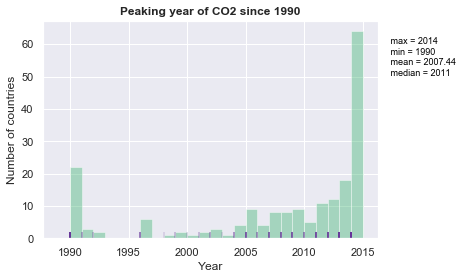

In [5]:
# Year of peaking since 1990

max_emis = data_years.max(axis=1)

year_max = data_years.idxmax(axis=1)
year_max = pd.to_numeric(year_max)
year_max.name = 'peak year'

start_year = min(list(map(int, data_years.columns)))
end_year = max(list(map(int, data_years.columns)))

make_histogram_peaking(year_max, variable, '', start_year, end_year, save_plot=False)
    

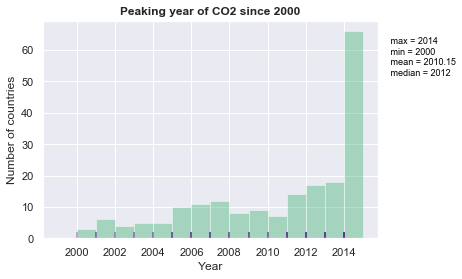

In [6]:
# Year of peaking since 2000

reduced_data = change_first_year(data_years, 2000)

year_max_2000 = reduced_data.idxmax(axis=1)
year_max_2000 = pd.to_numeric(year_max_2000)
year_max_2000.name = 'peak year'

start_year_2000 = min(list(map(int, reduced_data.columns)))
end_year_2000 = max(list(map(int, reduced_data.columns)))

make_histogram_peaking(year_max_2000, variable, '', start_year_2000, end_year_2000, save_plot=False)

"""
Note that the above code could be re-used for any year, not just 2000. 
"""
# TODO? - generalise the code to remove the '2000'. could then let the user specify the start year for counting! 

In [16]:
# part 3 - more nuanced version; what's the current trajectory?
# Fluctuating? Stalled? Or really decreasing? 

peaking_assessment = pd.DataFrame()
peaking_assessment['max year'] = year_max_2000
  
# Both of the options below work! If getting lots of boolean error issues, may just need to restart the kernel...

# Returns true for all countries that have their highest emissions BEFORE the last year of data
# Identfy countries that have 'peaked'
peaking_assessment['max_reached'] = peaking_assessment['max year'].apply(lambda x : (x < end_year_2000))

peaking_assessment['5year_peak'] = peaking_assessment['max year'].apply(
                                                                lambda x : (x < (end_year_2000 - 4)))

# identify countries with signficant decreasing trends
recent_trends, unit = calculate_trends(reduced_data, num_years_trend=5)
peaking_assessment['decreasing'] = recent_trends[str(end_year_2000)].apply(lambda x: (x < 0))
peaking_assessment['strongly_decreasing'] = recent_trends[str(end_year_2000)].apply(lambda x: (x < -2.5))

# sue multi-criteria to define different regimes
peaking_assessment['peaked'] = peaking_assessment['5year_peak'] & peaking_assessment['strongly_decreasing']
peaking_assessment['stabilised'] = peaking_assessment['5year_peak'] & peaking_assessment['decreasing']
peaking_assessment['possible'] = peaking_assessment['max_reached'] & peaking_assessment['decreasing']
peaking_assessment['not_peaked'] = (peaking_assessment['max_reached']== False) & (peaking_assessment['decreasing'] == False)
peaking_assessment['not max'] = (peaking_assessment['max_reached']== False)
  
# and use that to get some stats
share_peaked = peaking_assessment['peaked'].value_counts(normalize=True) 
share_stabilised = peaking_assessment['stabilised'].value_counts(normalize=True)
share_possible   = peaking_assessment['possible'].value_counts(normalize=True)
share_increasing = peaking_assessment['not_peaked'].value_counts(normalize=True)
share_not_max = peaking_assessment['not max'].value_counts(normalize=True)

# and print to screen...
print('')
print('Share of countries peaked is {:.1f}%'.format(share_peaked[True]*100))
print('Share of countries stabilised is {:.1f}%'.format(share_stabilised[True]*100))
print('Share of countries possibly stabilised is {:.1f}%'.format(share_possible[True]*100))
print('Share of countries still increasing is {:.1f}%'.format(share_increasing[True]*100))
print('Share of countries not at max value is {:.1f}%'.format(share_not_max[True]*100))
print('')


Averaging trend over 5 years.

Share of countries peaked is 13.8%
Share of countries stabilised is 25.6%
Share of countries possibly stabilised is 30.8%
Share of countries still increasing is 33.8%
Share of countries not at max value is 33.8%


IndexError: index 6 is out of bounds for axis 0 with size 6

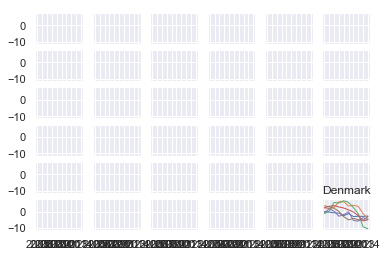

In [64]:
# Also need to check the results! 

sns.set(style="darkgrid", font_scale=1)

peaked_countries = recent_trends[peaking_assessment['peaked']]
count = 0
nplots = len(peaked_countries)
dim_plt = np.ceil(nplots**0.5)

fig, axs = plt.subplots(int(dim_plt), int(dim_plt), sharex='all', sharey='all')

for country in peaked_countries.index:
    
    print(count)
    print(country)
    count += 1
    
    axs[count] = plt.plot(peaked_countries.loc[country], linewidth=1)
    ax.axhline(linewidth=0.5, color='k')
    
    plt.title(to_name(country))
    
filepath = os.path.join('output', 'plots')
fname = ('peaking-' + country + '-' + variable + '.pdf')
if not os.path.exists(filepath):
    os.makedirs(filepath)
filename = os.path.join(filepath, fname)
plt.savefig(filename, format='pdf')
plt.close()
    
    
    
#     count += 1
#     fig, ax = plt.subplot(1, 2, 1)
#     #fig = plt.subplot(dim_plt, dim_plt, count)
#     #fig = plt.subplot(nplots, 1, count)
#     plt.plot(peaked_countries.loc[country], linewidth=1)
#     ax.axhline(linewidth=0.5, color='k')
    
#     fig, ax = plt.subplot(1, 2, 2)
#     #fig = plt.subplot(dim_plt, dim_plt, count)
#     #fig = plt.subplot(nplots, 1, count)
#     plt.plot(data_years.loc[country], linewidth=1)
#     ax.axhline(linewidth=0.5, color='k')
    
    
#     plt.title(to_name(country))
    
#     filepath = os.path.join('output', 'plots')
#     fname = ('peaking-' + country + '-' + variable + '.pdf')
#     if not os.path.exists(filepath):
#         os.makedirs(filepath)
#     filename = os.path.join(filepath, fname)
#     plt.savefig(filename, format='pdf')
#     plt.close()
    

In [17]:
def make_histogram_peaking(df, var, unit_, start_year, end_year, save_plot=False):
    
    """
    This is based on the make_simple_histogram function but caters to data that 
    contains both positive and negative values. For the GST, it's important to be 
    able to see whether or not trends etc. are positive or negative and a symmetric
    binning approach is needed. 
    
    To calculate the bin sizes, we use a couple of conditional rules based on the data
    available, including the max and min of the data and the number of data points. 
    For most plots we are expecting around 200 countries, but could also be a few regions. 
    
    TODO - the 'outlier' calculation is helpful to see some data better BUT need to be careful. 
    Proposed solution is to make BOTH plots so that it's clear to the user when data has been
    removed.
    
    TODO - 'df' is actually a series -> better name?
    """
    
    # Check the data - needs to not be, for example, all zeros
    if len(df.unique()) == 1:
        print('---------')
        print('All values in the series are the same! Exiting plotting routine for ' + str(var))
        print('---------')
        return
    
    # set a style
    sns.set(style="darkgrid") 
    
    
    # STATS
    # get some basic info about the data to use for setting styles, calculating bin sizes, and annotating plot
    maximum = int(max(df))
    minimum = int(min(df))
    mean = np.mean(df)
    median = np.median(df)
    npts = len(df) 

    # determine bin edges - annual!
    bin_width = 1 
    bins_calc = range((start_year-1), (end_year + 2), bin_width)                        
        
           
    # --------------        
    # MAKE THE PLOT
    
    # set up the figure
    fig, axs = plt.subplots()

    # make histogram
    sns.distplot(df, kde=False,
                 bins=bins_calc,
                 rug=False,   # with bins fixed at annual, the rugs aren't additional 
                 color='mediumseagreen',
                 rug_kws={"color": "rebeccapurple", "alpha": 0.7, "linewidth": 0.4, "height": 0.03})

    # Dynamically set x axis range to make symmetric abut 0
    if minimum < 0:
        # get and reset xmin or xmax
        xmin, xmax = axs.get_xlim()
        if np.absolute(xmax) > np.absolute(xmin):
            plt.xlim(-xmax, xmax)
        else:
            plt.xlim(xmin, -xmin)
        
        # and add a line at 0
        axs.axvline(linewidth=1, color='k')
           
    # Annotate the plot with stats
    axs.annotate((" max = {:.0f}".format(maximum) + 
                  "\n min = {:.0f}".format(minimum) + 
                  "\n mean = {:.2f}".format(mean) + 
                  "\n median = {:.0f}".format(median)),
                xy=(1.03, 0.75), xycoords=axs.transAxes,
                fontsize=9, color='black', 
                bbox=dict(facecolor='white', alpha=0.75))
    
    # label axes and add title
    axs.set_xlabel('Year')
    axs.set_ylabel('Number of countries')
    axs.set_title(('Peaking year of ' + var + ' since ' + str(start_year)), fontweight='bold')
    
    # show the plot
    plt.show()
    
    # save to file
    if save_plot:
        filepath = os.path.join('output', 'plots')
        fname = ('basic_histogram-' + var + '.pdf')
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        filename = os.path.join(filepath, fname)
        plt.savefig(filename, format='pdf')
        plt.close()

def change_first_year(df, new_start_year):

    # reduce the number of years (keeps things lighter and faster)
    year_cols = [y for y in df[df.columns] if (re.match(r"[0-9]{4,7}$", str(y)) is not None)]
    other_cols = list(set(df.columns) - set(year_cols))

    # set other columns as index
    if other_cols:
        df = df.set_index(other_cols)
    
    # identify which years to keep 
    last_year = max(year_cols)
    years_to_keep = np.arange(new_start_year, (int(last_year)+1), 1)
    years_keep_str = list(map(str, years_to_keep))

    # remove extra years
    df = df.loc[:, years_keep_str]

    # return other columns
    if other_cols:
        df = df.set_index(other_cols)
    # TODO - modify so that the output index is the same as the input!
    
    return df
        

# below also used elsewhere, add to utils!
def calculate_trends(df, num_years_trend=10): 
    
    # disp average used for trend
    print('Averaging trend over ' + str(num_years_trend) + ' years.')
    
    # calculate annual % changes
    df_perc_change = df.pct_change(axis='columns') * 100
    new_unit = '%'
    
    # average over a window
    df_rolling_average = df_perc_change.rolling(window=num_years_trend, axis='columns').mean()
    
    return df_rolling_average, new_unit

In [70]:
peaked_countries = test.set_index('country')
peaked_countries = peaked_countries.dropna(axis='columns')
peaked_countries

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
country,,,,,,,,,,
BEL,0.005425,-0.379190,-0.767540,-0.958016,-2.462966,-1.271903,-3.013752,-2.853193,-2.945359,-2.736705
BRB,2.191952,1.776218,2.473188,6.015993,5.927742,3.297819,3.841189,3.085321,-1.300810,-4.200656
CMR,-1.201222,0.280781,5.508843,5.129697,6.610601,5.512754,2.366149,-1.376369,-9.236369,-10.515634
CYP,2.338349,3.198749,3.570850,2.789551,2.135599,1.008699,-0.285723,-2.493472,-5.689499,-4.922536
DNK,-0.758290,1.672939,0.255131,-2.862170,-1.784464,-0.177064,-5.377964,-5.806352,-3.721102,-4.949636
ESP,3.473243,2.815321,1.980725,0.063334,-3.159360,-5.036438,-4.141689,-4.928424,-5.340585,-2.997051
FIN,0.650920,2.793778,1.247648,-3.839989,-3.445358,3.057966,-3.594151,-5.005647,-2.112581,-2.975216
GRC,2.032000,1.329596,1.780122,0.418673,-0.624465,-2.651482,-2.701732,-3.915975,-5.696118,-5.723693
HRV,3.580680,2.533976,2.480698,0.079820,-0.491608,-1.691846,-1.998526,-4.731907,-4.570366,-4.511846


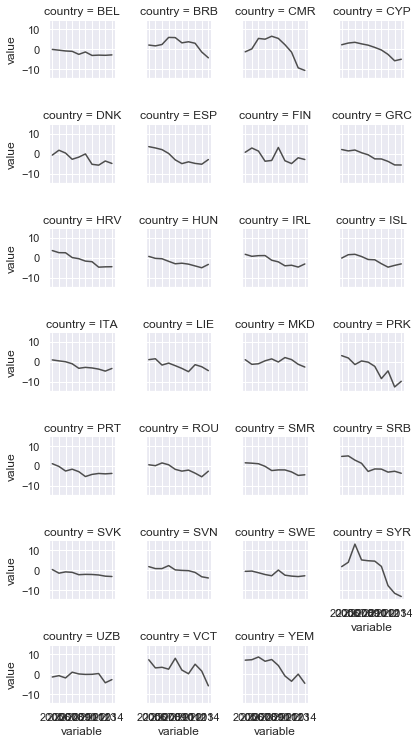

In [91]:
year_cols = peaked_countries.columns
#test = peaked_countries.T
test = peaked_countries.reset_index()
testa =  pd.melt(test, id_vars=['country'], value_vars=year_cols)
#test = pd.wide_to_long(test, , i="country", j=year_cols)
testa
grid = sns.FacetGrid(testa, col='country' , palette="tab20c",    col_wrap=4, height=1.5)
grid.map(sns.lineplot, "variable", "value", color=".3", ci=None);

In [33]:
recent_trends.loc['AFG']

2000          NaN
2001          NaN
2002          NaN
2003          NaN
2004          NaN
2005    13.965715
2006    17.866168
2007    19.333603
2008    34.105556
2009    50.583747
2010    47.113608
2011    50.946638
2012    40.757560
2013    22.350811
2014    12.353463
Name: AFG, dtype: float64

In [87]:
attend = sns.load_dataset("attention").query("subject <= 12")
attend

#g = sns.FacetGrid(attend, col="subject", col_wrap=4, height=2, ylim=(0, 10))
#g.map(sns.pointplot, "solutions", "score", color=".3", ci=None);

,Unnamed: 0,subject,attention,solutions,score
0,0,1,divided,1,2.0
1,1,2,divided,1,3.0
2,2,3,divided,1,3.0
3,3,4,divided,1,5.0
4,4,5,divided,1,4.0
5,5,6,divided,1,5.0
6,6,7,divided,1,5.0
7,7,8,divided,1,5.0
8,8,9,divided,1,2.0
9,9,10,divided,1,6.0


In [88]:
testa

,country,variable,value
0,BEL,2005,0.005425
1,BRB,2005,2.191952
2,CMR,2005,-1.201222
3,CYP,2005,2.338349
4,DNK,2005,-0.758290
5,ESP,2005,3.473243
6,FIN,2005,0.650920
7,GRC,2005,2.032000
8,HRV,2005,3.580680
9,HUN,2005,0.653080
